## Big Data Technology
## Assignment III
## Nick Olivier (qdj592)
## 10/16/2018

### Packages

In [1]:
import numpy as np, pandas as pd, bs4 as bs, matplotlib.pyplot as plt, seaborn as sns
import nltk, urllib.parse, urllib.request, string
from nltk.corpus import stopwords
from urllib.error import URLError
from bs4 import BeautifulSoup
from selenium import webdriver
import time, re, string
from time import sleep
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances

### User Input

In [2]:
url_list = ['https://en.wikipedia.org/wiki/World_War_II',
            'https://en.wikipedia.org/wiki/World_War_I',
            'https://en.wikipedia.org/wiki/War_of_1812',
            'https://en.wikipedia.org/wiki/Basketball',
            'https://en.wikipedia.org/wiki/Association_football']

xpath_list = ['//p', '//p', '//p', '//p', '//p']

file_name_list = ['WWII', 'WWI', 'War of\n1812', 'Basketball', 'Assoc.\nFootball']

ph_path = 'C:/tmp/phantomjs.exe'

### Define Functions

In [3]:
def punc_repl(s):
    for c in string.punctuation:
        s=s.replace(c,"")
    return s

def semi_rand_intervals(max_time, n_nums):
    return np.random.choice(np.linspace(0, max_time, 1000), n_nums)

def phantom_scrape(phan_path, web_url, x_path):
    # Driver
    driver = webdriver.PhantomJS(executable_path = phan_path)
    driver.get(web_url)
    # Random Sleep Intervals
    time.sleep(semi_rand_intervals(2,1))
    tmp_list = []
    for i in driver.find_elements_by_xpath(x_path):
        tmp_list.append(i.text)
        time.sleep(semi_rand_intervals(.35,1))
    return tmp_list

def scrape_clean_tokenize(phan_path, web_url, x_path, file_nm):
    stops = set(stopwords.words("english"))
    tmp = phantom_scrape(phan_path, web_url, x_path)
    raw_txt = max(tmp, key=len)
    bt_txt = BeautifulSoup(raw_txt, "lxml").get_text()
    cl_txt = re.sub('\d', ' ', punc_repl(bt_txt))
    wd_lst = nltk.word_tokenize(cl_txt)
    lower_wd_lst = [s.lower() for s in wd_lst]
    filt_wd_lst = [w for w in lower_wd_lst if w not in stops]
    output_df = pd.DataFrame({'file': file_nm,
                              'word': filt_wd_lst})
    return output_df

def scrape_clean_tokenize_mult(phan_path, web_url_lst, x_path_lst, file_nm_lst):
    pl_holder = []
    for i, x in enumerate(web_url_lst):
        tmp = scrape_clean_tokenize(phan_path,
                                    web_url_lst[i],
                                    x_path_lst[i],
                                    file_nm_lst[i])
        pl_holder.append(tmp)
    output_df = pd.concat(pl_holder, axis = 0, ignore_index = True)
    return output_df
        
def token_df_to_cos_matrix(token_df, top_n_words = 20):
    uniq_files = [uf for uf in set(token_df['file'])]
    uniq_words = [uw for uw in set(token_df['word'])]
    word_counts = []
    for uw in uniq_words:
        word_counts.append(len([w for w in token_df['word'] if w == uw]))
    word_count_df = pd.DataFrame({'word': uniq_words,
                                  'word_count': word_counts}).\
    sort_values('word_count', ascending=False).\
    head(top_n_words)
    top_uniq_words = [w for w in word_count_df['word']]
    outer_plholder = []
    for file in uniq_files:
        inner_plholder = []
        for word in top_uniq_words:
            wlist = [w for w in token_df[token_df.file == file]['word']]
            inner_plholder.append(wlist.count(word))
        outer_plholder.append(inner_plholder)
    cos_matrix = 1-pairwise_distances(outer_plholder, metric='cosine')
    return cos_matrix

def plt_cos_matrix(cos_matrix, names, plt_title):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cos_matrix, vmin=0, vmax=1)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names)
    ax.set_yticks(np.arange(len(names)))
    ax.set_yticklabels(names)
    plt.title(plt_title, y=1.1)
    plt.show()

### Execute Functions

C:\Users\user\Anaconda3\envs\febenv\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


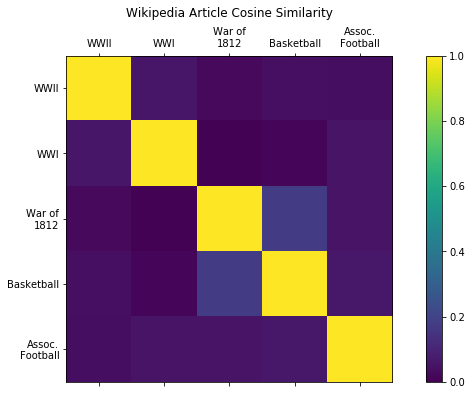

In [5]:
tokens = scrape_clean_tokenize_mult(ph_path, url_list, xpath_list, file_name_list)
cos_matrix = token_df_to_cos_matrix(tokens, top_n_words = 5000)
plt_cos_matrix(cos_matrix, file_name_list, 'Wikipedia Article Cosine Similarity')